In [1]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
%matplotlib inline
 
# import the necessary packages
from keras.layers.core import Flatten, Dense, Dropout, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, Nadam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.initializers import RandomNormal, Constant
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.applications.nasnet import NASNetLarge
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet201
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.applications.vgg19 import VGG19
from keras.utils import to_categorical
from keras.layers import Input
from keras.layers import  concatenate
import keras.backend as K
from keras import optimizers
from keras.models import Model
from imutils import paths
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from scipy.misc import imresize 
import tensorflow as tf
import numpy as np
import argparse
import random
import cv2
import os

/home/soroka/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Data loading

In [2]:
path = 'data/raw/'
def get_all_solutions():
    ### Import solutions file and load into self.solutions
    import csv
    all_solutions = {}
    with open(path+'training_solutions_rev1.csv', 'r') as f:
        reader = csv.reader(f, delimiter=",")
        next(reader)
        for i, line in enumerate(reader):
            all_solutions[line[0]] = [float(x) for x in line[1:]]
    return all_solutions

solutions = get_all_solutions()

In [3]:
import time
from skimage.transform import resize
start_time = time.time()

imagePaths = list(paths.list_images(path + 'train'))
imagePaths.sort()
data = np.zeros((len(imagePaths), 224, 224, 3), dtype="uint8")
labels = []

for count, imagePath in enumerate(imagePaths):
    # load the image, pre-process it, and store it in the data list
    img = cv2.imread(imagePath)

    data[count] = img[100:324, 100:324,:]
    #data[count, :, :, :] = imresize(tmp,size=(150,150,3),interp="cubic")

    
print("--- %s seconds ---" % (time.time() - start_time))
np.save("train_full_data.npy", data)

--- 79.7598168849945 seconds ---


In [4]:
import time
from skimage.transform import resize
start_time = time.time()

imagePaths = list(paths.list_images(path + 'valid'))
imagePaths.sort()
data = np.zeros((len(imagePaths), 224, 224, 3), dtype="uint8")
labels = []

for count, imagePath in enumerate(imagePaths):
    # load the image, pre-process it, and store it in the data list
    img = cv2.imread(imagePath)

    
    data[count] = img[100:324, 100:324,:]
    #data[count, :, :, :] = imresize(tmp,size=(150,150,3),interp="cubic")
    
    
print("--- %s seconds ---" % (time.time() - start_time))
np.save("valid_full_data.npy", data)

--- 26.190526485443115 seconds ---


In [5]:
data = np.load("train_full_data.npy")
valid_data = np.load("valid_full_data.npy")

labels = []
valid_labels = []

imagePaths = list(paths.list_images(path + 'train'))
imagePaths.sort()
for count, imagePath in enumerate(imagePaths):
    label = solutions[imagePath.split(os.path.sep)[-1].split('.')[0]]
    labels.append(label)
    
imagePaths = list(paths.list_images(path + 'valid'))
imagePaths.sort()
for count, imagePath in enumerate(imagePaths):
    label = solutions[imagePath.split(os.path.sep)[-1].split('.')[0]]
    valid_labels.append(label)

In [6]:
classes, batch_size =  37, 18

train_generator = ImageDataGenerator(rotation_range=360,
                                     width_shift_range = 0.02,
                                     height_shift_range = 0.02,
                                     data_format="channels_last")
valid_generator = ImageDataGenerator(data_format="channels_last")

train = train_generator.flow(data, labels, batch_size = batch_size)
valid = valid_generator.flow(valid_data, valid_labels, batch_size = batch_size)

[[ 5.  5.  5. ...  7. 11. 12.]
 [ 3.  3.  3. ...  7. 11. 12.]
 [ 2.  2.  2. ...  7. 11. 12.]
 ...
 [ 7.  8.  7. ...  2.  2.  2.]
 [ 7.  8.  7. ...  0.  0.  0.]
 [ 7.  8.  7. ...  0.  0.  0.]]
[[ 8.  8.  8. ...  8. 12. 13.]
 [ 6.  6.  6. ...  8. 12. 13.]
 [ 4.  4.  4. ...  8. 12. 13.]
 ...
 [ 6.  7.  6. ...  3.  3.  3.]
 [ 6.  7.  6. ...  1.  1.  1.]
 [ 6.  7.  6. ...  0.  0.  0.]]


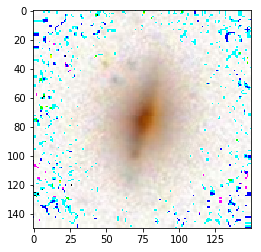

In [5]:
import matplotlib.pyplot as plt

for x, y in train:
    p = np.zeros(x[0].shape)
    p[:,:,0] = x[0,:,:,2]
    p[:,:,1] = x[0,:,:,1]
    p[:,:,2] = x[0,:,:,0]
    plt.imshow(x[0])
    print(x[0,:,:,0])
    print(x[0,:,:,1])
    break


# Main vs. Pre-trained models

In [3]:
batch_size = 18
minibatch, height, width, channels = batch_size, 224, 224, 3
eps = 1e-12   

def winner_activation(x):
    
    '''return tf.stack([x[:, :3] / (tf.reduce_sum(x[:, :3], axis=1)[..., None] + eps),
                    x[:, 3:5] / (tf.reduce_sum(x[:, 3:5], axis=1)[..., None] + eps),
                    x[:, 5:7] / (tf.reduce_sum(x[:, 5:7], axis=1)[..., None] + eps),
                    x[:, 7:9] / (tf.reduce_sum(x[:, 7:9], axis=1)[..., None] + eps),
                    x[:, 9:13] / (tf.reduce_sum(x[:, 9:13], axis=1)[..., None] + eps),
                    x[:, 13:15] / (tf.reduce_sum(x[:, 13:15], axis=1)[..., None] + eps),
                    x[:, 15:18] / (tf.reduce_sum(x[:, 15:18], axis=1)[..., None] + eps),
                    x[:, 18:25] / (tf.reduce_sum(x[:, 18:25], axis=1)[..., None] + eps),
                    x[:, 25:28] / (tf.reduce_sum(x[:, 25:28], axis=1)[..., None] + eps),
                    x[:, 28:31] / (tf.reduce_sum(x[:, 28:31], axis=1)[..., None] + eps),
                    x[:, 31:37] / (tf.reduce_sum(x[:, 31:37], axis=1)[..., None] + eps)], axis=1)'''
    
    
    return tf.stack([x[:,0]/(tf.reduce_sum(x[:,:3], axis = 1)[...] + eps),
                                x[:,1]/(tf.reduce_sum(x[:,:3], axis = 1)[...] + eps),
                                x[:,2]/(tf.reduce_sum(x[:,:3], axis = 1)[...] + eps),
                                x[:,3]/(tf.reduce_sum(x[:,3:5], axis = 1)[...] + eps),
                                x[:,4]/(tf.reduce_sum(x[:,3:5], axis = 1)[...] + eps),
                                x[:,5]/(tf.reduce_sum(x[:,5:7], axis = 1)[...] + eps),
                                x[:,6]/(tf.reduce_sum(x[:,5:7], axis = 1)[...] + eps),
                                x[:,7]/(tf.reduce_sum(x[:,7:9], axis = 1)[...] + eps),
                                x[:,8]/(tf.reduce_sum(x[:,7:9], axis = 1)[...] + eps),
                                x[:,9]/(tf.reduce_sum(x[:,9:13], axis = 1)[...] + eps),
                                x[:,10]/(tf.reduce_sum(x[:,9:13], axis = 1)[...] + eps),
                                x[:,11]/(tf.reduce_sum(x[:,9:13], axis = 1)[...] + eps),
                                x[:,12]/(tf.reduce_sum(x[:,9:13], axis = 1)[...] + eps),
                                x[:,13]/(tf.reduce_sum(x[:,13:15], axis = 1)[...] + eps),
                                x[:,14]/(tf.reduce_sum(x[:,13:15], axis = 1)[...] + eps),
                                x[:,15]/(tf.reduce_sum(x[:,15:18], axis = 1)[...] + eps),
                                x[:,16]/(tf.reduce_sum(x[:,15:18], axis = 1)[...] + eps),
                                x[:,17]/(tf.reduce_sum(x[:,15:18], axis = 1)[...] + eps),
                                x[:,18]/(tf.reduce_sum(x[:,18:25], axis = 1)[...] + eps),
                                x[:,19]/(tf.reduce_sum(x[:,18:25], axis = 1)[...] + eps),
                                x[:,20]/(tf.reduce_sum(x[:,18:25], axis = 1)[...] + eps),
                                x[:,21]/(tf.reduce_sum(x[:,18:25], axis = 1)[...] + eps),
                                x[:,22]/(tf.reduce_sum(x[:,18:25], axis = 1)[...] + eps),
                                x[:,23]/(tf.reduce_sum(x[:,18:25], axis = 1)[...] + eps),
                                x[:,24]/(tf.reduce_sum(x[:,18:25], axis = 1)[...] + eps),
                                x[:,25]/(tf.reduce_sum(x[:,25:28], axis = 1)[...] + eps),
                                x[:,26]/(tf.reduce_sum(x[:,25:28], axis = 1)[...] + eps),
                                x[:,27]/(tf.reduce_sum(x[:,25:28], axis = 1)[...] + eps),
                                x[:,28]/(tf.reduce_sum(x[:,28:31], axis = 1)[...] + eps),
                                x[:,29]/(tf.reduce_sum(x[:,28:31], axis = 1)[...] + eps),
                                x[:,30]/(tf.reduce_sum(x[:,28:31], axis = 1)[...] + eps),
                                x[:,31]/(tf.reduce_sum(x[:,31:37], axis = 1)[...] + eps),
                                x[:,32]/(tf.reduce_sum(x[:,31:37], axis = 1)[...] + eps),
                                x[:,33]/(tf.reduce_sum(x[:,31:37], axis = 1)[...] + eps),
                                x[:,34]/(tf.reduce_sum(x[:,31:37], axis = 1)[...] + eps),
                                x[:,35]/(tf.reduce_sum(x[:,31:37], axis = 1)[...] + eps),
                                x[:,36]/(tf.reduce_sum(x[:,31:37], axis = 1)[...] + eps)
                                ], axis = 1)
    
    

def ConvPart(inputs):
    bn = BatchNormalization()(inputs)
    
    core = Conv2D(filters = 32, kernel_size = 6, activation = 'relu', kernel_initializer=RandomNormal(0, 0.01), bias_initializer=Constant(0.1))(bn)
    core = MaxPooling2D((2,2), strides=(2,2))(core)
    core = Conv2D(filters = 64, kernel_size = 5, activation = 'relu', kernel_initializer=RandomNormal(0, 0.01), bias_initializer=Constant(0.1))(core)
    core = MaxPooling2D((2,2), strides=(2,2))(core)
    core = Conv2D(filters = 128, kernel_size = 3, activation = 'relu', kernel_initializer=RandomNormal(0, 0.01), bias_initializer=Constant(0.1))(core)
    core = Conv2D(filters = 128, kernel_size = 3, activation = 'relu', kernel_initializer=RandomNormal(0, 0.1), bias_initializer=Constant(0.1))(core)
    core = MaxPooling2D((2,2), strides=(2,2))(core)
    return core


"""def win():
    inputs = Input(batch_shape=(batch_size,height, width, channels))
    core = Flatten()(ConvPart(inputs))
    outputs = keras.layers.maximum([Dense(4096,kernel_initializer=RandomNormal(0, 0.001), bias_initializer=Constant(0.01))(core), Dense(4096,kernel_initializer=RandomNormal(0, 0.001), bias_initializer=Constant(0.01))(core)])
    outputs = Dropout(0.5)(outputs)
    #outputs = MaxoutDense(2048,  nb_feature=2)(outputs)
    outputs = keras.layers.maximum([Dense(2048,kernel_initializer=RandomNormal(0, 0.001), bias_initializer=Constant(0.01))(outputs), Dense(2048,kernel_initializer=RandomNormal(0, 0.001), bias_initializer=Constant(0.01))(outputs)])
    outputs = Dropout(0.5)(outputs)
    outputs = Dense(37, activation='relu',kernel_initializer=RandomNormal(0, 0.01), bias_initializer=Constant(0.1))(outputs)

    return Model(inputs, outputs)"""

def win():
    inputs = Input(batch_shape = (batch_size, height, width, channels))
    bn = BatchNormalization()(inputs)
    
    #base_model = Xception(input_tensor = bn, input_shape=(height, width, channels), weights=None, classes=1000)
    #base_model = VGG16(input_tensor = bn, input_shape=(height, width, channels), weights=None, classes=1000)
    #base_model = VGG19(input_tensor = bn, input_shape=(height, width, channels), weights=None, classes=1000)
    #base_model = ResNet50(input_tensor = bn, input_shape=(height, width, channels), weights=None, classes=1000)
    #base_model = InceptionV3(input_tensor = bn, input_shape=(height, width, channels), weights=None, classes=1000)
    #base_model = InceptionResNetV2(input_tensor = bn, input_shape=(height, width, channels), weights=None, classes=1000)
    #base_model = MobileNet(input_tensor = bn, input_shape=(height, width, channels), weights=None, classes=1000)
    #base_model = DenseNet121(input_tensor = bn, input_shape=(height, width, channels), weights=None, classes=1000)
    #base_model = DenseNet169(input_tensor = bn, input_shape=(height, width, channels), weights=None, classes=1000)
    base_model = DenseNet201(input_tensor = bn, input_shape=(height, width, channels), weights=None, classes=1000)
    #base_model = NasNetLarge(input_tensor = bn, input_shape=(height, width, channels), weights=None, classes=1000)
    
    base = Dropout(0.5)(base_model.output)
    base = Dense(37, kernel_initializer = RandomNormal(0, 0.01), bias_initializer = Constant(0.1))(base)
    
    #base = Activation(winner_activation)(base)
    
    x = base_model.output

    return Model(inputs= base_model.input, outputs=base)

model = win()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (18, 224, 224, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (18, 224, 224, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (18, 230, 230, 3)    0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (18, 112, 112, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (

In [9]:
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

#model.load_weights('nasnet_pretrained_50.h5')

#sgd = optimizers.SGD(lr=0.0004,momentum = 0.9, nesterov = True)
#adam = Adam(lr = 0.01)
model.compile('adam', loss = 'mse', metrics=[rmse, 'accuracy'])
#model.compile(sgd, loss = 'mse', metrics=[rmse, 'accuracy'])
history = model.fit_generator(epochs=100,
                              generator=train,
                              steps_per_epoch=data.shape[0]//batch_size,
                              validation_data = valid,
                              validation_steps = valid_data.shape[0]//batch_size,
                              callbacks=[ModelCheckpoint('densenet201_pretrained_100.h5',
                                                                         save_best_only=True, 
                                                                         save_weights_only=True)])
np.save('densenet201_pretrained_100_history.npy', history.history)

Epoch 1/100
3110/3110 [==============================] - 3911s 1s/step - loss: 0.0241 - rmse: 0.1455 - acc: 0.6023 - val_loss: 0.0202 - val_rmse: 0.1306 - val_acc: 0.6240
Epoch 2/100
3110/3110 [==============================] - 3735s 1s/step - loss: 0.0163 - rmse: 0.1184 - acc: 0.6788 - val_loss: 0.0152 - val_rmse: 0.1157 - val_acc: 0.6845
Epoch 3/100
3110/3110 [==============================] - 3750s 1s/step - loss: 0.0132 - rmse: 0.1061 - acc: 0.7240 - val_loss: 0.0138 - val_rmse: 0.1082 - val_acc: 0.7317
Epoch 4/100
3110/3110 [==============================] - 3753s 1s/step - loss: 0.0119 - rmse: 0.1006 - acc: 0.7342 - val_loss: 0.0108 - val_rmse: 0.0954 - val_acc: 0.7799
Epoch 5/100
3110/3110 [==============================] - 3741s 1s/step - loss: 0.0111 - rmse: 0.0971 - acc: 0.7441 - val_loss: 0.0114 - val_rmse: 0.0977 - val_acc: 0.7763
Epoch 6/100
3110/3110 [==============================] - 3746s 1s/step - loss: 0.0105 - rmse: 0.0947 - acc: 0.7474 - val_loss: 0.0105 - val_rmse:

Epoch 49/100
3110/3110 [==============================] - 3728s 1s/step - loss: 0.0068 - rmse: 0.0768 - acc: 0.7992 - val_loss: 0.0068 - val_rmse: 0.0761 - val_acc: 0.8273
Epoch 50/100
3110/3110 [==============================] - 3732s 1s/step - loss: 0.0068 - rmse: 0.0768 - acc: 0.7980 - val_loss: 0.0067 - val_rmse: 0.0752 - val_acc: 0.8282
Epoch 51/100
3110/3110 [==============================] - 3727s 1s/step - loss: 0.0068 - rmse: 0.0766 - acc: 0.7992 - val_loss: 0.0067 - val_rmse: 0.0757 - val_acc: 0.8219
Epoch 52/100
3110/3110 [==============================] - 3726s 1s/step - loss: 0.0068 - rmse: 0.0766 - acc: 0.7973 - val_loss: 0.0066 - val_rmse: 0.0749 - val_acc: 0.8248
Epoch 53/100
3110/3110 [==============================] - 3729s 1s/step - loss: 0.0067 - rmse: 0.0762 - acc: 0.7992 - val_loss: 0.0069 - val_rmse: 0.0766 - val_acc: 0.8294
Epoch 54/100
3110/3110 [==============================] - 3725s 1s/step - loss: 0.0067 - rmse: 0.0763 - acc: 0.7985 - val_loss: 0.0068 - val

# Answer building

In [4]:
import time
start_time = time.time()

imagePaths = list(paths.list_images(path + 'images_test_rev1'))
imagePaths.sort()
data = np.zeros((len(imagePaths) + 17, 224, 224, 3), dtype="uint8")
labels = []

for count, imagePath in enumerate(imagePaths):
    # load the image, pre-process it, and store it in the data list
    img = cv2.imread(imagePath)

    
    data[count] = img[100:324, 100:324,:]
    #data[count, :, :, :] = imresize(tmp,size=(150,150,3),interp="cubic")
 
    # extract the class label from the image path and update the
    # labels list
    #label = solutions[imagePath.split(os.path.sep)[-1].split('.')[0]]
    #label = 1 if label == "santa" else 0
    #labels.append(label)
    
for i in range(17):
    data[len(imagePaths) + i] = data[i]
    
print("--- %s seconds ---" % (time.time() - start_time))
np.save("test_full_data.npy", data)

--- 283.7295355796814 seconds ---


In [8]:
test_data = np.load("test_full_data.npy")

test_labels = []
    
imagePaths = list(paths.list_images(path + 'images_test_rev1'))
imagePaths.sort()
for count, imagePath in enumerate(imagePaths):
    test_labels.append(imagePath.split(os.path.sep)[-1].split('.')[0])
    
for i in range(17):
    test_labels.append(imagePaths[i].split(os.path.sep)[-1].split('.')[0])
    

In [16]:
import math
import time
start_time = time.time()
eps = 1e-12
model.load_weights('densenet201_pretrained_100.h5')
predictions = model.predict(test_data, batch_size = batch_size)

print(predictions.shape)

predictions
print("--- %s seconds ---" % (time.time() - start_time))

(79992, 37)
--- 1624.0556108951569 seconds ---


In [ ]:
predictions


# Answer normalization

In [ ]:
predictions[:, :3] = predictions[:, :3] / (predictions[:, :3].sum(axis=1)[..., None] + eps)
predictions[:, 3:5] = predictions[:, 3:5] / (predictions[:, 3:5].sum(axis=1)[..., None] + eps)
predictions[:, 5:7] = predictions[:, 5:7] / (predictions[:, 5:7].sum(axis=1)[..., None] + eps)
predictions[:, 7:9] = predictions[:, 7:9] / (predictions[:, 7:9].sum(axis=1)[..., None] + eps)
predictions[:, 9:13] = predictions[:, 9:13] / (predictions[:, 9:13].sum(axis=1)[..., None] + eps)
predictions[:, 13:15] = predictions[:, 13:15] / (predictions[:, 13:15].sum(axis=1)[..., None] + eps)
predictions[:, 15:18] = predictions[:, 15:18] / (predictions[:, 15:18].sum(axis=1)[..., None] + eps)
predictions[:, 18:25] = predictions[:, 18:25] / (predictions[:, 18:25].sum(axis=1)[..., None] + eps)
predictions[:, 25:28] = predictions[:, 25:28] / (predictions[:, 25:28].sum(axis=1)[..., None] + eps)
predictions[:, 28:31] = predictions[:, 28:31] / (predictions[:, 28:31].sum(axis=1)[..., None] + eps)
predictions[:, 31:37] = predictions[:, 31:37] / (predictions[:, 31:37].sum(axis=1)[..., None] + eps)

predictions

# First layer filters visualization

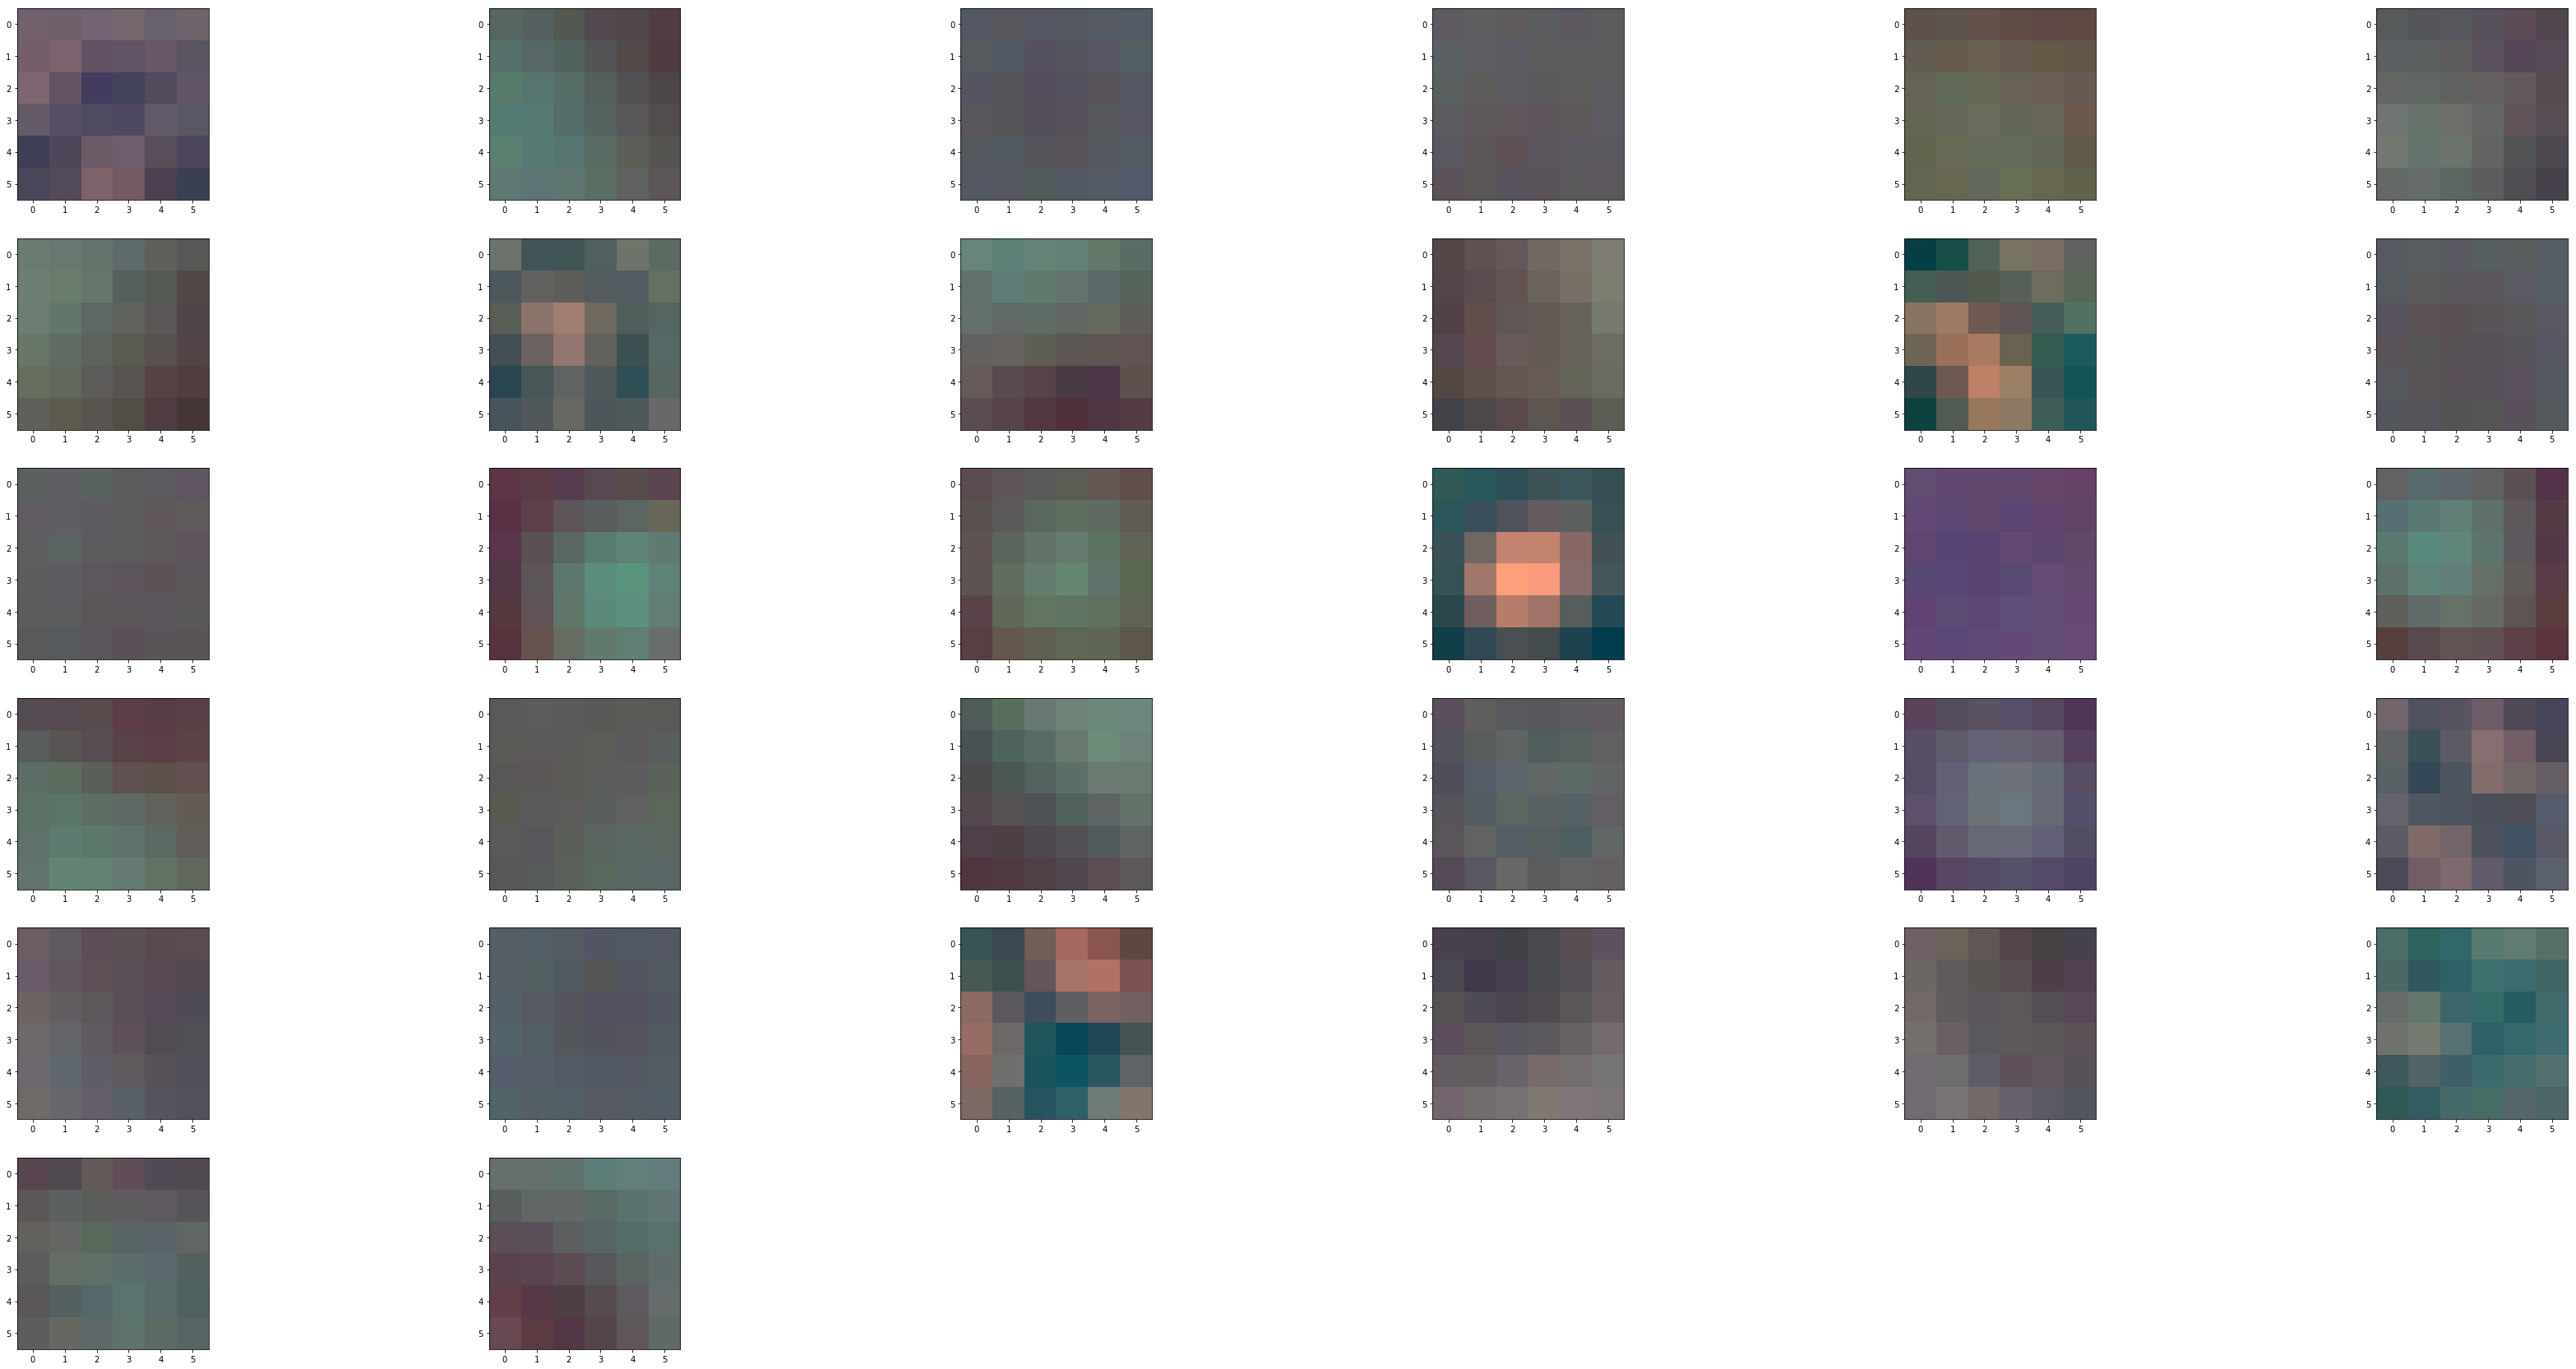

In [10]:
layer_num = 2
weights = (model.layers[layer_num].get_weights()[0]) 
weights.shape

weights -= weights.min()
weights /= weights.max()



    
fig=plt.figure(figsize=(weights.shape[1]*10, weights.shape[2]*10))
for x in range(32):
    fig.add_subplot(6, 6, x + 1)
    plt.imshow(weights[:,:,:,x])

    
plt.show()

In [5]:
classes, batch_size =  37, 18

test_generator = ImageDataGenerator(data_format="channels_last")

test = test_generator.flow(test_data, test_labels, batch_size = batch_size, shuffle = False)

In [44]:
fig=plt.figure(figsize=(x.shape[1], x.shape[2]))
for x, y in test:
    x = x.astype(dtype = 'uint8')
    
    for i in range(x.shape[0]):
        fig.add_subplot(4, 5, i + 1)
        plt.imshow(x[i])
    print
    break
    
plt.show()

In [13]:
import math
import time
start_time = time.time()
eps = 1e-12
model.load_weights('win_50_weights.h5')
predictions = model.predict_generator(test,
                       steps = math.ceil(len(imagePaths)/batch_size))

print(predictions.shape)

predictions
print("--- %s seconds ---" % (time.time() - start_time))

(79992, 37)
--- 179.92680954933167 seconds ---


In [9]:
np.set_printoptions(formatter={'float': '{: 0.38f}'.format})

In [13]:
predictions[:, :3] = predictions[:, :3] / (predictions[:, :3].sum(axis=1)[..., None] + eps)
predictions[:, 3:5] = predictions[:, 3:5] / (predictions[:, 3:5].sum(axis=1)[..., None] + eps)
predictions[:, 5:7] = predictions[:, 5:7] / (predictions[:, 5:7].sum(axis=1)[..., None] + eps)
predictions[:, 7:9] = predictions[:, 7:9] / (predictions[:, 7:9].sum(axis=1)[..., None] + eps)
predictions[:, 9:13] = predictions[:, 9:13] / (predictions[:, 9:13].sum(axis=1)[..., None] + eps)
predictions[:, 13:15] = predictions[:, 13:15] / (predictions[:, 13:15].sum(axis=1)[..., None] + eps)
predictions[:, 15:18] = predictions[:, 15:18] / (predictions[:, 15:18].sum(axis=1)[..., None] + eps)
predictions[:, 18:25] = predictions[:, 18:25] / (predictions[:, 18:25].sum(axis=1)[..., None] + eps)
predictions[:, 25:28] = predictions[:, 25:28] / (predictions[:, 25:28].sum(axis=1)[..., None] + eps)
predictions[:, 28:31] = predictions[:, 28:31] / (predictions[:, 28:31].sum(axis=1)[..., None] + eps)
predictions[:, 31:37] = predictions[:, 31:37] / (predictions[:, 31:37].sum(axis=1)[..., None] + eps)

header = open('all_zeros_benchmark.csv','r').readlines()[0]

with open('win_50_submission.csv','w') as outfile:
    outfile.write(header)
    for i in range(len(test_labels )- 17):
        id_ = test_labels[i]
        pred = predictions[i]
        outline = id_ + "," + ",".join([str("{:.38f}".format(x)) for x in pred])
        outfile.write(outline + "\n")

In [17]:
with open('densenet201_100_submission.csv','w') as outfile:
    outfile.write(header)
    for i in range(len(test_labels )- 17):
        id_ = test_labels[i]
        pred = predictions[i]
        outline = id_ + "," + ",".join([str("{:.38f}".format(x)) for x in pred])
        outfile.write(outline + "\n")

In [20]:
predictions[1,13] + predictions[1,14]  

0.99999994